In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

fatal: destination path 'colab-biolab' already exists and is not an empty directory.
./
./root/
./root/.profile
./root/.tmux.conf
./root/.bashrc.biolab
./root/.vimrc
./root/.bin.priority/
./root/.bin.priority/pip
./root/.bin.priority/pip3
./root/.bin.priority/pip2
./root/.condarc
PREFIX=/root/conda
Unpacking payload ...
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to contr

In [3]:
!conda install -y bedtools bioawk samtools

Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /root/conda

  added / updated specs:
    - bedtools
    - bioawk
    - samtools


The following packages will be UPDATED:

  ca-certificates    pkgs/main/linux-64::ca-certificates-2~ --> conda-forge/noarch::ca-certificates-2025.6.15-hbd8a1cb_0 
  certifi            pkgs/main/linux-64::certifi-2025.4.26~ --> conda-forge/noarch::certifi-2025.6.15-pyhd8ed1ab_0 
  conda              pkgs/main::conda-25.3.1-py313h06a4308~ --> conda-forge::conda-25.5.1-py313h78bf25f_0 
  openssl              pkgs/main::openssl-3.0.16-h5eee18b_0 --> conda-forge::openssl-3.5.0-h7b32b05_1 




Preparing transaction: - done
Verifying transaction: | / done
Executing transaction:

In [4]:
%cd /content/drive/MyDrive/binfo1-work/

/content/drive/MyDrive/binfo1-work


In [5]:
!pip install goatools

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy


In [8]:
with open("read-counts.txt", "r") as f:
    lines = f.readlines()
    comment_lines = [line for line in lines if line.startswith("#")]

# 전처리 1: 주석 제외 데이터 읽어서 Dataframe으로 만듦, 데이터 구조 파악
df = pd.read_csv("read-counts.txt", sep="\t", comment="#")

print(df.columns.tolist())
print(df.head())

['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'CLIP-35L33G.bam', 'CLIP-let7g.bam', 'filterd-RPF-siLuc.bam', 'filtered-RPF-siLin28a.bam', 'filtered-RPF-siLuc.bam', 'RNA-control.bam', 'RNA-siLin28a.bam', 'RNA-siLuc.bam', 'RPF-siLin28a.bam', 'RPF-siLuc.bam']
                 Geneid                                 Chr  \
0  ENSMUSG00000102693.2                                chr1   
1  ENSMUSG00000064842.3                                chr1   
2  ENSMUSG00000051951.6  chr1;chr1;chr1;chr1;chr1;chr1;chr1   
3  ENSMUSG00000102851.2                                chr1   
4  ENSMUSG00000103377.2                                chr1   

                                               Start  \
0                                            3143476   
1                                            3172239   
2  3276124;3276746;3283662;3283832;3284705;349192...   
3                                            3322980   
4                                            3435954   

                    

In [9]:
#전처리2: Geneid가 인덱스, log2FC 값을 계산하여 새로운 컬럼 추가 -> 새로운 dataframe 계산
import numpy as np
import pandas as pd

df = pd.read_csv("read-counts.txt", sep="\t", comment="#")
df = df.set_index("Geneid")

# pseudocount 추가
df["log2fc_CLIP"] = np.log2((df["CLIP-35L33G.bam"] + 1) / (df["RNA-control.bam"] + 1))
df["log2fc_RNA"]  = np.log2((df["RNA-siLin28a.bam"] + 1) / (df["RNA-siLuc.bam"] + 1))
df["log2fc_RIBO"] = np.log2((df["RPF-siLin28a.bam"] + 1) / (df["RPF-siLuc.bam"] + 1))

log2fc = df[["log2fc_CLIP", "log2fc_RNA", "log2fc_RIBO"]].dropna()

print(log2fc.head())

                      log2fc_CLIP  log2fc_RNA  log2fc_RIBO
Geneid                                                    
ENSMUSG00000102693.2     0.000000         0.0          0.0
ENSMUSG00000064842.3     0.000000         0.0          0.0
ENSMUSG00000051951.6     1.321928         0.0          0.0
ENSMUSG00000102851.2     2.000000         0.0          0.0
ENSMUSG00000103377.2     0.000000         0.0          0.0


In [10]:
!rm -f gene2go gene2go.gz*.gz # 기존 gene2go 파일 및 gz 파일들 모두 삭제
!wget -O gene2go.gz https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz # gene2go.gz 파일로 명확하게 다운로드
!gunzip -f gene2go.gz # 강제로 압축 해제 시도

--2025-06-16 09:45:26--  https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1204421813 (1.1G) [application/x-gzip]
Saving to: ‘gene2go.gz’

gene2go.gz          100%[===================>]   1.12G  47.3MB/s    in 22s     

2025-06-16 09:45:48 (52.3 MB/s) - ‘gene2go.gz’ saved [1204421813/1204421813]



In [11]:
!ls

category_boxplot.png
cds_counts_deseq2.csv
CLIP-35L33G.bam
CLIP-35L33G.bam.bai
CLIP-let7g.bam
CLIP-let7g-clean.pileup
CLIP-let7g-gene.pileup
CLIP-let7g.pileup
colab-biolab
correct_analysis.png
distributions.png
entropy.bedgraph
er_bound_mrnas_analysis.png
ER_GO_enrichment_TE.csv
exon_lines.txt
filterd-RPF-siLuc.bam
filtered-RPF-siLin28a.bam
filtered-RPF-siLuc.bam
fivepcounts-filtered-RPF-siLin28a.txt
fivepcounts-filtered-RPF-siluc.txt
fivepcounts-filtered-RPF-siLuc.txt
fivepcounts-RPF-siLin28a.bed
fivepcounts-RPF-siLuc.bed
gencode-exons-containing-startcodon.bed
gencode-exon-sorted.gtf
gencode.gtf
gencode-plusexon.gtf
gencode-start.gtf
gencode-start-sorted.gtf
gene2go
gene2go_fixed.gz
gene2go.gz.1
gene2go.gz.2
gene2go.gz.3
gene2go.gz.4
gene2go.gz.5
gene_info.gz.1
go_df_filtered.csv
GO_enrichment_comparison.csv
go_enrichment_fisher.xlsx
go_terms.obo
GSE37114_family.soft.gz
kegg_mapping.txt
lin28a_bound_significant_genes.csv
lin28a_effect_analysis.png
lin28a_effect_scatter.png
lin28a_loc

In [12]:
#전처리: 전처리 과정 섹션 내에서: 실험 데이터 전처리(log2FC 계산, ID 매핑 등)를 설명한 후에, "GO enrichment 분석을 위해 필요한 GO 데이터베이스와 유전자-GO 매핑 정보를 준비하는 단계"로 이 셀의 내용을 소개합니다.
#역할 강조: 이 셀이 GO 분석 도구인 GOATOOLS가 사용할 배경 지식(GO 용어 정의)과 분석 대상 유전자들의 주석 정보(유전자-GO 연결)를 로딩하는 중요 역할을 한다는 점을 강조합니다.
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go

obodag = GODag("go_terms.obo")
#GO 용어의 정의와 관계를 담고 있는 파일
gene2go = read_ncbi_gene2go("gene2go", taxids=[10090])
#파일의 데이터 중 마우스에 해당하는 데이터의 유전자-GO term 연결 정보를 읽어온다. (key: gene ID, dictionary: related GO term ID)
print(f"Mouse 유전자 수: {len(gene2go)}개")
#GO term 매핑 정보가 로딩된 마우스 유전자의 총 개수

go_terms.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms
DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: <ipython-input-12-1846756424> BY <cell line: 0>
HMS:0:03:30.422518 612,814 annotations, 29,819 genes, 19,327 GOs, 1 taxids READ: gene2go 
19261 IDs in loaded association branch, BP
Mouse 유전자 수: 19261개


In [13]:
#확인용
!ls -lh /content/mart_export.txt

-rw-r--r-- 1 root root 1.7M Jun 16 09:34 /content/mart_export.txt


In [14]:
#확인용
!head /content/mart_export.txt

Gene stable ID,NCBI gene (formerly Entrezgene) ID
ENSMUSG00000064336,
ENSMUSG00000064337,
ENSMUSG00000064338,
ENSMUSG00000064339,
ENSMUSG00000064340,
ENSMUSG00000064341,17716
ENSMUSG00000064342,
ENSMUSG00000064343,
ENSMUSG00000064344,


In [20]:
#전처리 3: Ensembl ID의 버전 정보를 제거한 후 진행
fc = pd.read_csv("log2fc_all_genes.csv", index_col=0)
fc["gene_id_clean"] = fc.index.str.split(".").str[0]

In [57]:
#전처리 4: NaN 값이 있는 행 제거, GeneID 컬럼의 데이터를 문자열로 변경, log2fc와 병합 (Ensembl gene ID -> Entrez gene ID, 유전자 발현 데이터에 추가, GO 분석과 같이 Entrez ID를 사용하는 분석을 위해 필수적이다.)
mapping_df = pd.read_csv("/content/mart_export.txt")
mapping_df.columns = ["EnsemblID", "GeneID"]
mapping_df = mapping_df.dropna()
mapping_df["GeneID"] = mapping_df["GeneID"].astype(str)
fc_mapped=fc.merge(mapping_df, left_on="gene_id_clean", right_on="EnsemblID", how="left")

In [37]:
fc.head()

log2fc_CLIP  log2fc_RNA  log2fc_RIBO       gene_id_clean  \
0     0.000000         0.0          0.0  ENSMUSG00000102693   
1     0.000000         0.0          0.0  ENSMUSG00000064842   
2     1.321928         0.0          0.0  ENSMUSG00000051951   
3     2.000000         0.0          0.0  ENSMUSG00000102851   
4     0.000000         0.0          0.0  ENSMUSG00000103377   

            EnsemblID       GeneID  
0                 NaN          NaN  
1  ENSMUSG00000064842  115487594.0  
2  ENSMUSG00000051951     497097.0  
3                 NaN          NaN  
4                 NaN          NaN

In [22]:
fc.columns

Index(['log2fc_CLIP', 'log2fc_RNA', 'log2fc_RIBO', 'gene_id_clean'], dtype='object')

In [23]:
fc.shape

(55359, 4)

In [25]:
fc[fc["GeneID"].isna()].shape

KeyError: 'GeneID'

In [58]:
#전처리 5: GeneID 컬럼 데이터 문자열 형식으로 통일 - ID 일치하기 위해서.
fc_mapped["GeneID"].head()

0            NaN
1    115487594.0
2       497097.0
3            NaN
4            NaN
Name: GeneID, dtype: object

In [27]:
genes_in_go = [str(gid) for gid, gos in gene2go.items() if "GO:0006412" in gos]
print(genes_in_go[:5])

['11651', '12877', '13627', '13628', '13629']


In [59]:
fc_mapped["GeneID"] = fc_mapped["GeneID"].astype(float).map(
    lambda x: str(int(x)) if pd.notna(x) else None # NaN이 아니면 int 변환 후 str, NaN이면 None
)

print(fc_mapped["GeneID"].head())

#.0 제거

0         None
1    115487594
2       497097
3         None
4         None
Name: GeneID, dtype: object


In [30]:
#분석 및 결과 해석: GO terms와 유전자 간의 관계 정보 (gene2go)와 GO 용어 정의 (obodag) 로딩 - GO 데이터베이스와 계층 구조 정보 fetch
go_data = []

for go_id, term in obodag.items():
    genes_in_go = [str(gid) for gid, gos in gene2go.items() if go_id in gos]
    matched = fc_mapped[fc_mapped["GeneID"].isin(genes_in_go)]

    if len(matched) >= 3:
        avg_clip = matched["log2fc_CLIP"].mean()
        avg_ribo = matched["log2fc_RIBO"].mean()
        avg_rna = matched["log2fc_RNA"].mean()

        go_data.append({
            "GO_ID": go_id,
            "Description": term.name,
            "N_genes": len(matched),
            "avg_CLIP": avg_clip,
            "avg_RIBO": avg_ribo,
            "avg_RNA": avg_rna
        })

print(f"GO term: {len(go_data)}")

go = pd.DataFrame(go_data)

GO term: 7948


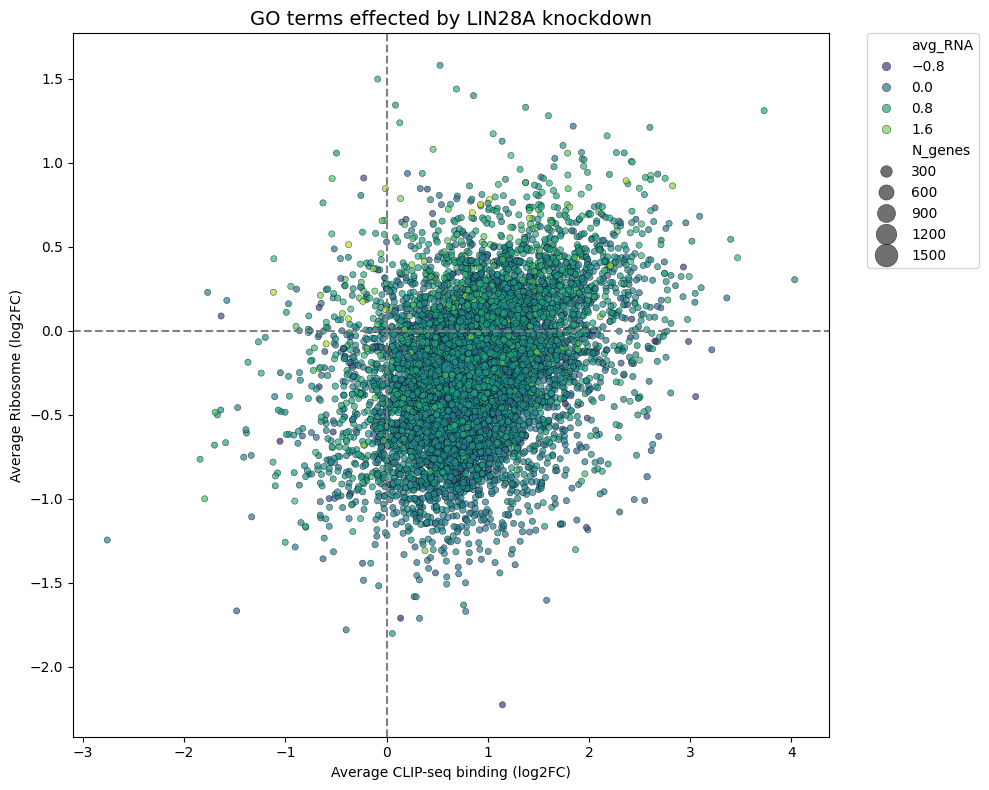

In [40]:
#분석: scatterplot 형성 - GO term 수준에서 LIN28A 결합 변화 (CLIP)와 번역 변화 (Ribo) 관계를 visualize, RNA 발현 변화의 영향을 색으로 구분
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=go,
    x="avg_CLIP", y="avg_RIBO",
    size="N_genes", hue="avg_RNA",
    palette="viridis", sizes=(20, 300), edgecolor="black", alpha=0.7
)
scatter.set_title("GO terms effected by LIN28A knockdown", fontsize=14)
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Average CLIP-seq binding (log2FC)")
plt.ylabel("Average Ribosome (log2FC)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()
#too many data points

In [35]:
#확인용
matched_terms = 0

for go_id, term in obodag.items():
    genes_in_go = [str(gid) for gid, gos in gene2go.items() if go_id in gos]
    matched = fc_mapped[fc_mapped["GeneID"].isin(genes_in_go)]

    if len(matched) >= 3:
        matched_terms += 1
        print(f"{go_id}: matched {len(matched)}")

print("GO terms:", matched_terms)

GO:0000002: matched 10
GO:0000012: matched 13
GO:0000027: matched 12
GO:0000028: matched 13
GO:0000038: matched 22
GO:0000045: matched 106
GO:0000050: matched 11
GO:0000052: matched 3
GO:0000054: matched 6
GO:0000055: matched 8
GO:0000056: matched 9
GO:0000070: matched 34
GO:0000076: matched 9
GO:0000077: matched 50
GO:0000079: matched 7
GO:0000082: matched 83
GO:0000086: matched 47
GO:0000103: matched 4
GO:0000122: matched 984
GO:0000132: matched 38
GO:0000154: matched 5
GO:0000165: matched 139
GO:0000183: matched 7
GO:0000184: matched 36
GO:0000209: matched 160
GO:0000212: matched 10
GO:0000226: matched 151
GO:0000237: matched 6
GO:0000239: matched 4
GO:0000244: matched 11
GO:0000245: matched 18
GO:0000255: matched 12
GO:0000266: matched 20
GO:0000271: matched 7
GO:0000272: matched 3
GO:0000278: matched 116
GO:0000280: matched 8
GO:0000281: matched 62
GO:0000288: matched 15
GO:0000289: matched 13
GO:0000290: matched 13
GO:0000301: matched 10
GO:0000302: matched 23
GO:0000303: matched

KeyboardInterrupt: 

In [36]:
# 전체 유전자 ID 비교
set_gene_ids = set(fc_mapped["GeneID"])
set_go_ids = set()
for go_id in obodag:
    set_go_ids.update([str(gid) for gid, gos in gene2go.items() if go_id in gos])

# 교집합 수 확인
overlap = set_gene_ids.intersection(set_go_ids)
print("GO에 실제로 존재하는 GeneID 수:", len(overlap))

GO에 실제로 존재하는 GeneID 수: 18587


In [37]:
go_filtered = go[go["N_genes"] >= 20] #조정 가능
print("GO terms:", go_filtered.shape[0])
go_filtered.head()

GO terms: 1728


GO_ID                                   Description  N_genes  \
4   GO:0000038  very long-chain fatty acid metabolic process       22   
5   GO:0000045                        autophagosome assembly      106   
11  GO:0000070          mitotic sister chromatid segregation       34   
13  GO:0000077               DNA damage checkpoint signaling       50   
15  GO:0000082         G1/S transition of mitotic cell cycle       83   

    avg_CLIP  avg_RIBO   avg_RNA  
4   0.299706 -0.445780  0.246371  
5   0.554468 -0.386305  0.473393  
11  0.831462 -0.895953  0.240427  
13  0.442054 -0.584931  0.151481  
15  0.895297 -0.500317  0.379229

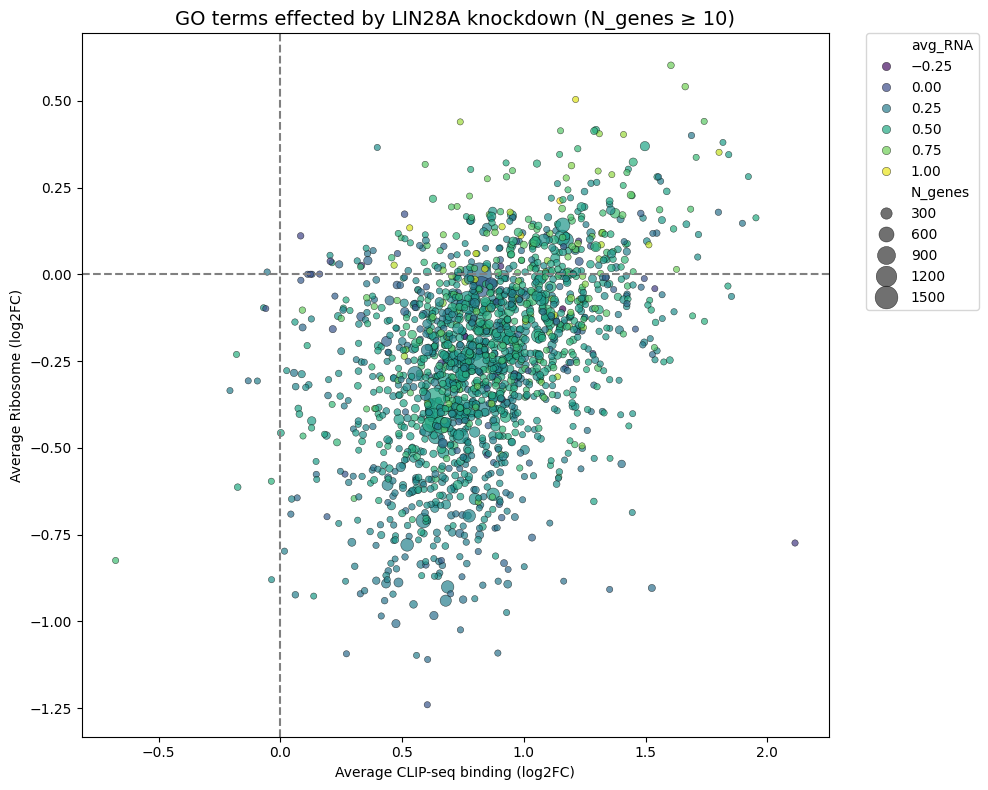

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=go_filtered,
    x="avg_CLIP", y="avg_RIBO",
    size="N_genes", hue="avg_RNA",
    palette="viridis", sizes=(20, 300),
    edgecolor="black", alpha=0.7
)

scatter.set_title("GO terms effected by LIN28A knockdown (N_genes ≥ 10)", fontsize=14)
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Average CLIP-seq binding (log2FC)")
plt.ylabel("Average Ribosome (log2FC)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

In [77]:
fc_mapped = fc_mapped.rename(columns={
    "log2fc_CLIP": "CLIP_log2FC",
    "log2fc_RNA": "RNA_log2FC",
    "log2fc_RIBO": "Ribo_log2FC"
})

In [74]:
#전처리: TE = Ribo_log2FC - RNA_log2FC
fc_mapped["TE_log2FC"] = fc_mapped["Ribo_log2FC"] - fc_mapped["RNA_log2FC"]

display(fc_mapped[["GeneID", "Ribo_log2FC", "RNA_log2FC", "TE_log2FC"]].head())

GeneID  Ribo_log2FC  RNA_log2FC  TE_log2FC
0       None          0.0         0.0        0.0
1  115487594          0.0         0.0        0.0
2     497097          0.0         0.0        0.0
3       None          0.0         0.0        0.0
4       None          0.0         0.0        0.0

In [63]:
background = fc_mapped["GeneID"].dropna()
background = background.astype(float).astype(int).astype(str)
print("background:", len(background))

background: 27474


In [68]:
gene2go_strkeys = {str(k): v for k, v in gene2go.items()}

In [75]:
#TE가 높은 유전자 선정 (log2FC > 1)
top_TE = fc_mapped[fc_mapped["TE_log2FC"] > 1]
top_gene_ids = top_TE["GeneID"].dropna().astype(str).tolist()

In [76]:
#total genes
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy

goea = GOEnrichmentStudy(
    list(background), gene2go_strkeys, obodag, methods=['fdr_bh'], alpha=0.05, prt=None)

results = goea.run_study(list(top_gene_ids))
print(len(results))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 68% 18,617 of 27,474 population items found in association

Runing  Ontology Analysis: current study set of 1384 IDs.
 62%    858 of  1,384 study items found in association
100%  1,384 of  1,384 study items found in population(27474)
Calculating 14,984 uncorrected p-values using fisher_scipy_stats
  14,984 terms are associated with 18,587 of 27,474 population items
   5,494 terms are associated with    858 of  1,384 study items
  METHOD fdr_bh:
     157 GO terms found significant (< 0.05=alpha) ( 16 enriched + 141 purified): statsmodels fdr_bh
     362 study items associated with significant GO IDs (enriched)
     858 study items associated with significant GO IDs (purified)
14984


In [78]:
fc_mapped = fc_mapped.rename(columns={
    "log2fc_CLIP": "CLIP_log2FC",
    "log2fc_RNA": "RNA_log2FC",
    "log2fc_RIBO": "Ribo_log2FC"
})

In [80]:
# 분석: GO enrichment 실행
#background와 gene list 준비
goea_results = goea.run_study(top_gene_ids)
print("Fisher GO enrichment:", len(goea_results))


Runing  Ontology Analysis: current study set of 1384 IDs.
 62%    858 of  1,384 study items found in association
100%  1,384 of  1,384 study items found in population(27474)
Calculating 14,984 uncorrected p-values using fisher_scipy_stats
  14,984 terms are associated with 18,587 of 27,474 population items
   5,494 terms are associated with    858 of  1,384 study items
  METHOD fdr_bh:
     157 GO terms found significant (< 0.05=alpha) ( 16 enriched + 141 purified): statsmodels fdr_bh
     362 study items associated with significant GO IDs (enriched)
     858 study items associated with significant GO IDs (purified)
Fisher GO enrichment: 14984


In [81]:
fc_mapped = fc_mapped.rename(columns={
    "log2fc_CLIP": "CLIP_log2FC",
    "log2fc_RNA": "RNA_log2FC",
    "log2fc_RIBO": "Ribo_log2FC"
})

In [83]:
# go_summary 생성
go2genes = {}
for r in goea_results:
    go_id = r.GO
    genes = r.study_items
    if len(genes) >= 10:
        go2genes[go_id] = genes

records = []
for go_id, gene_list in go2genes.items():
    sub = fc_mapped[fc_mapped["GeneID"].astype(str).isin(gene_list)]
    if len(sub) < 3: continue
    records.append({
        "GO": go_id,
        "GO_name": next((r.name for r in goea_results if r.GO == go_id), ""),
        "FDR": next((r.p_fdr_bh for r in goea_results if r.GO == go_id), 1),
        "N_genes": len(sub),
        "avg_CLIP": sub["CLIP_log2FC"].mean(),
        "avg_Ribo": sub["Ribo_log2FC"].mean(),
        "avg_RNA": sub["RNA_log2FC"].mean()
    })

go_summary = pd.DataFrame(records)
go_summary = go_summary.sort_values("FDR")

print("total GO terms:", len(go_summary))
go_summary.head()

total GO terms: 706


GO                                           GO_name  \
296  GO:0006139  nucleobase-containing compound metabolic process   
297  GO:0090304                    nucleic acid metabolic process   
298  GO:0044238                         primary metabolic process   
299  GO:0008152                                 metabolic process   
300  GO:0016070                             RNA metabolic process   

              FDR  N_genes  avg_CLIP  avg_Ribo   avg_RNA  
296  2.091919e-20       36  0.853362  0.756401 -1.327987  
297  7.966177e-19       22  1.055262  0.710866 -1.444479  
298  1.970507e-18      198  1.045873  0.856285 -1.074920  
299  8.186271e-16      253  1.026189  0.796787 -1.138658  
300  1.485314e-15       11  0.875117  0.423214 -1.433892

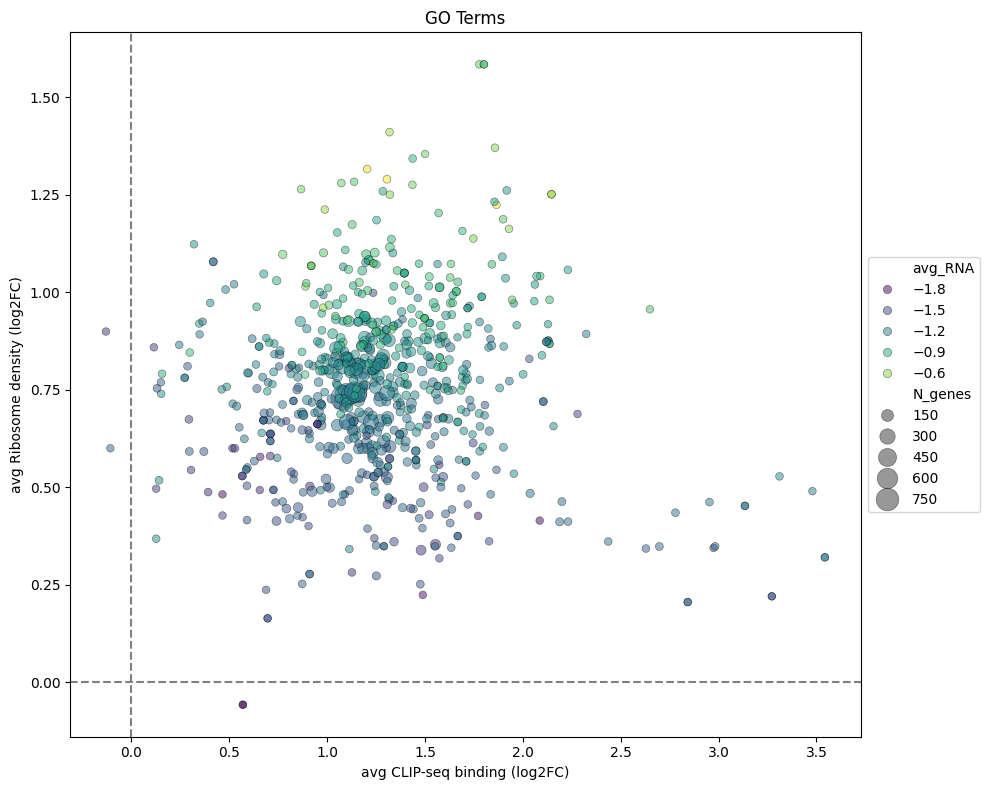

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=go_summary,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(30, 300),
    palette="viridis",
    edgecolor="black",
    alpha=0.5
)

plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("avg CLIP-seq binding (log2FC)")
plt.ylabel("avg Ribosome density (log2FC)")
plt.title("GO Terms")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [90]:
highlight_terms = go_summary[go_summary["FDR"] < 0.001]
highlight_terms = go_summary.sort_values("FDR").head(30)

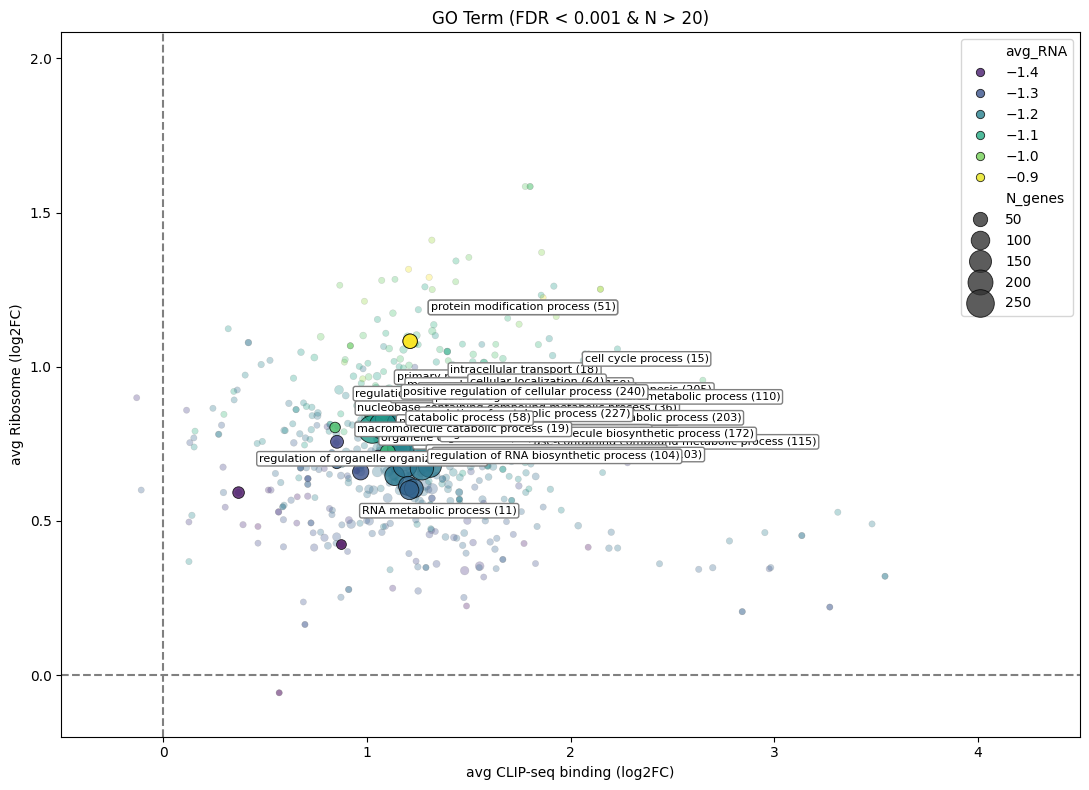

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 유의미한 GO term만 필터링
highlight_terms = go_summary.sort_values("FDR").head(30) #조정 가능

plt.figure(figsize=(11, 8))

sns.scatterplot(
    data=go_summary,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(20, 250),
    palette="viridis",
    edgecolor="gray",
    alpha=0.3,
    legend=False
)

# 강조
sns.scatterplot(
    data=highlight_terms,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(50, 400),
    palette="viridis",
    edgecolor="black",
    alpha=0.8,
    legend="brief"
)

# 말풍선 추가
for _, row in highlight_terms.iterrows():
    plt.text(
        row["avg_CLIP"] + 0.1,
        row["avg_Ribo"] + 0.1,
        f"{row['GO_name']} ({row['N_genes']})",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.2")
    )

# 축 및 시각 설정
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlim(-0.5, 4.5)  # X축 확장
plt.ylim(-0.2, go_summary["avg_Ribo"].max() + 0.5)
plt.xlabel("avg CLIP-seq binding (log2FC)")
plt.ylabel("avg Ribosome (log2FC)")
plt.title("GO Term (FDR < 0.001 & N > 20)")
plt.tight_layout()
plt.show()

In [92]:
!pip install adjustText

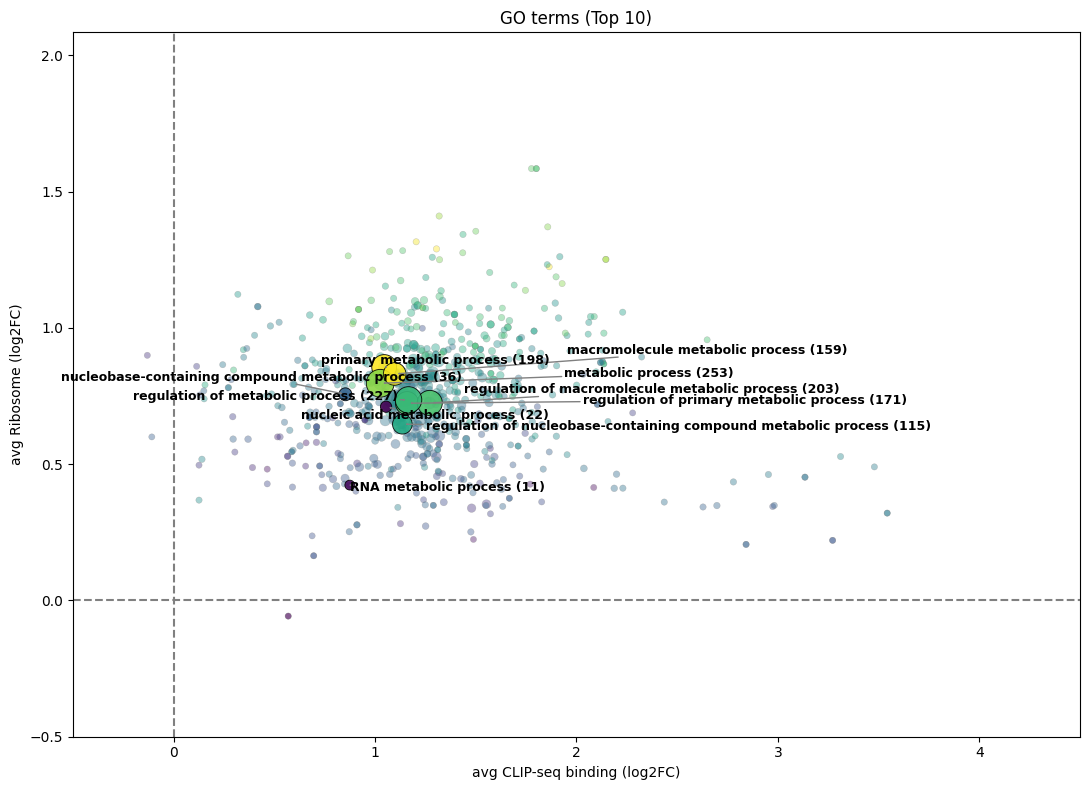

In [93]:
#분석: 최대한 Fig5A 재현, 대상이 달라서 다른 결과 도출
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns

#상위 10개 GO
top_labels = go_summary.sort_values("FDR").head(10)

plt.figure(figsize=(11, 8))

sns.scatterplot(
    data=go_summary,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(20, 250),
    palette="viridis",
    edgecolor="gray",
    alpha=0.4,
    legend=False
)

sns.scatterplot(
    data=top_labels,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(50, 400),
    palette="viridis",
    edgecolor="black",
    alpha=0.9,
    legend=False
)

texts = []
for _, row in top_labels.iterrows():
    texts.append(
        plt.text(
            row["avg_CLIP"],
            row["avg_Ribo"],
            f"{row['GO_name']} ({row['N_genes']})",
            fontsize=9,
            weight="bold"
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color="gray", lw=1),
    only_move={"points": "y", "text": "xy"}
)

plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, go_summary["avg_Ribo"].max() + 0.5)
plt.xlabel("avg CLIP-seq binding (log2FC)")
plt.ylabel("avg Ribosome (log2FC)")
plt.title("GO terms (Top 10)")
plt.tight_layout()
plt.show()

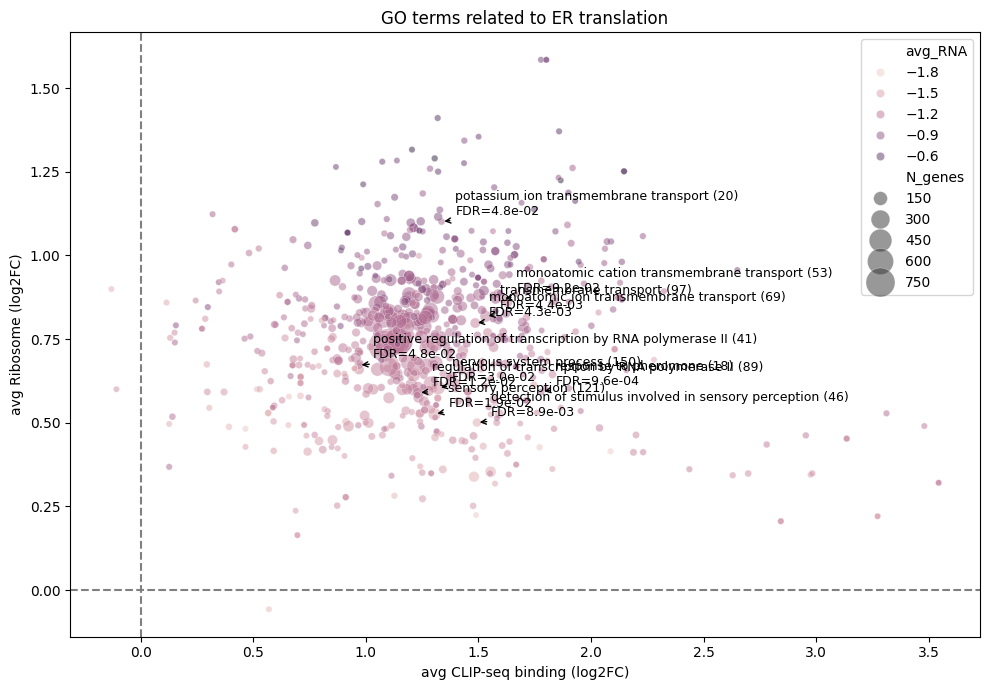

In [94]:
#ER-related terms only (복습 혹은 제외)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

er_keywords = ["endoplasmic", "ER", "reticulum", "Golgi", "lumen", "membrane"]

er_related = go_summary[go_summary["GO_name"].str.contains('|'.join(er_keywords), case=False)]

highlight_terms = er_related.sort_values("FDR").head(10)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=go_summary,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(20, 500),
    alpha=0.5,
    legend="brief"
)

plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')

for i, row in highlight_terms.iterrows():
    plt.annotate(
        f"{row['GO_name']} ({row['N_genes']})\nFDR={row['FDR']:.1e}",
        (row["avg_CLIP"], row["avg_Ribo"]),
        textcoords="offset points",
        xytext=(10, 5),
        ha='left',
        fontsize=9,
        arrowprops=dict(arrowstyle="->", lw=1, color='black')
    )

plt.title("GO terms related to ER translation")
plt.xlabel("avg CLIP-seq binding (log2FC)")
plt.ylabel("avg Ribosome (log2FC)")
plt.tight_layout()
plt.show()

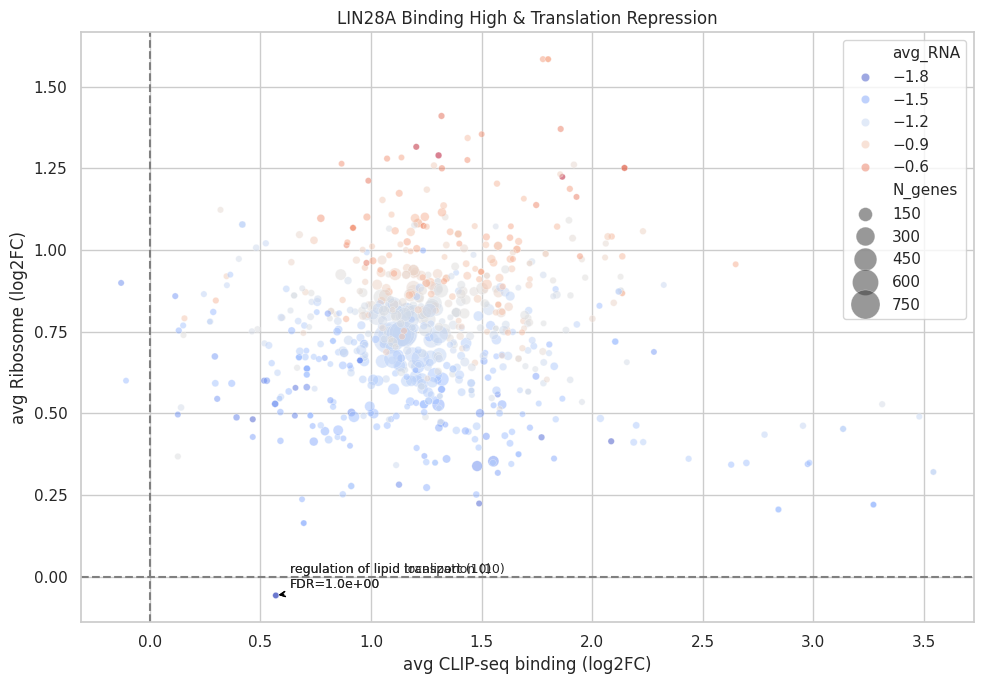

In [95]:
#제외
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

highlight_repression = go_summary[
    (go_summary["avg_CLIP"] > 0.5) & (go_summary["avg_Ribo"] < 0)
].sort_values("FDR").head(10)

plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.scatterplot(
    data=go_summary,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(20, 500),
    alpha=0.5,
    palette="coolwarm",
    legend="brief"
)

plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')

for i, row in highlight_repression.iterrows():
    plt.annotate(
        f"{row['GO_name']} ({row['N_genes']})\nFDR={row['FDR']:.1e}",
        (row["avg_CLIP"], row["avg_Ribo"]),
        textcoords="offset points",
        xytext=(10, 5),
        ha='left',
        fontsize=9,
        arrowprops=dict(arrowstyle="->", lw=1, color='black')
    )

plt.title("LIN28A Binding High & Translation Repression")
plt.xlabel("avg CLIP-seq binding (log2FC)")
plt.ylabel("avg Ribosome (log2FC)")
plt.tight_layout()
plt.show()

In [96]:
print("조건을 만족하는 term:", highlight_repression.shape[0])
highlight_repression.head()

조건을 만족하는 term: 2


GO                           GO_name  FDR  N_genes  avg_CLIP  \
245  GO:1905952  regulation of lipid localization  1.0       10  0.569528   
182  GO:0032368     regulation of lipid transport  1.0       10  0.569528   

     avg_Ribo   avg_RNA  
245 -0.057469 -1.824674  
182 -0.057469 -1.824674

Suppression of ER-related translation: 0


Empty DataFrame
Columns: [GO_name, avg_CLIP, avg_Ribo, FDR]
Index: []

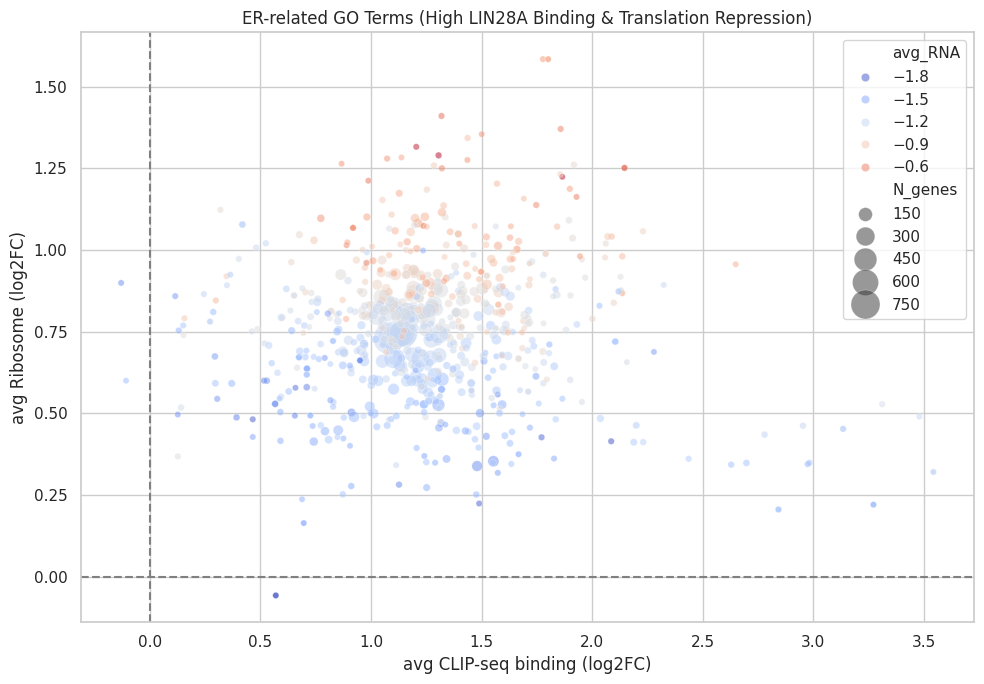

In [97]:
#제외
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

er_keywords = ["endoplasmic", "ER", "reticulum", "lumen", "membrane", "Golgi"]

er_related = go_summary[
    go_summary["GO_name"].str.contains('|'.join(er_keywords), case=False)
]

er_repressed = er_related[
    (er_related["avg_CLIP"] > 1) & (er_related["avg_Ribo"] < 0)
].sort_values("FDR")

print("Suppression of ER-related translation:", er_repressed.shape[0])
display(er_repressed[["GO_name", "avg_CLIP", "avg_Ribo", "FDR"]].head(10))

# 시각화
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.scatterplot(
    data=go_summary,
    x="avg_CLIP",
    y="avg_Ribo",
    hue="avg_RNA",
    size="N_genes",
    sizes=(20, 500),
    alpha=0.5,
    palette="coolwarm",
    legend="brief"
)

plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')

# 말풍선 (상위 10개만 표시)
for i, row in er_repressed.head(10).iterrows():
    plt.annotate(
        f"{row['GO_name']} ({row['N_genes']})\nFDR={row['FDR']:.1e}",
        (row["avg_CLIP"], row["avg_Ribo"]),
        textcoords="offset points",
        xytext=(20, 10),
        ha='left',
        fontsize=9,
        arrowprops=dict(arrowstyle="->", lw=1.2, color='black')
    )

plt.title("ER-related GO Terms (High LIN28A Binding & Translation Repression)")
plt.xlabel("avg CLIP-seq binding (log2FC)")
plt.ylabel("avg Ribosome (log2FC)")
plt.tight_layout()
plt.show()

In [98]:
print("ER term:", er_repressed.shape[0])
display(er_repressed[["GO_name", "avg_CLIP", "avg_Ribo", "FDR"]])


ER term: 0


Empty DataFrame
Columns: [GO_name, avg_CLIP, avg_Ribo, FDR]
Index: []

In [99]:
er_loose = er_related[
    (er_related["avg_CLIP"] > 0.5) & (er_related["avg_Ribo"] < 0.2)
].sort_values("FDR")

print("완화 조건 ER term:", er_loose.shape[0])
display(er_loose[["GO_name", "avg_CLIP", "avg_Ribo", "FDR"]])


완화 조건 ER term: 0


Empty DataFrame
Columns: [GO_name, avg_CLIP, avg_Ribo, FDR]
Index: []

In [102]:
!ls

category_boxplot.png
cds_counts_deseq2.csv
CLIP-35L33G.bam
CLIP-35L33G.bam.bai
CLIP-let7g.bam
CLIP-let7g-clean.pileup
CLIP-let7g-gene.pileup
CLIP-let7g.pileup
colab-biolab
correct_analysis.png
distributions.png
entropy.bedgraph
er_bound_mrnas_analysis.png
ER_GO_enrichment_TE.csv
exon_lines.txt
filterd-RPF-siLuc.bam
filtered-RPF-siLin28a.bam
filtered-RPF-siLuc.bam
fivepcounts-filtered-RPF-siLin28a.txt
fivepcounts-filtered-RPF-siluc.txt
fivepcounts-filtered-RPF-siLuc.txt
fivepcounts-RPF-siLin28a.bed
fivepcounts-RPF-siLuc.bed
gencode-exons-containing-startcodon.bed
gencode-exon-sorted.gtf
gencode.gtf
gencode-plusexon.gtf
gencode-start.gtf
gencode-start-sorted.gtf
gene2go
gene2go_fixed.gz
gene2go.gz.1
gene2go.gz.2
gene2go.gz.4
gene2go.gz.5
gene_info.gz.1
go_df_filtered.csv
GO_enrichment_comparison.csv
go_enrichment_fisher.xlsx
go_terms.obo
GSE37114_family.soft.gz
kegg_mapping.txt
lin28a_bound_significant_genes.csv
lin28a_effect_analysis.png
lin28a_effect_scatter.png
lin28a_localization_sca

In [154]:
!rm -f gene2go.gz gene2go
!wget -O gene2go.gz ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
!gunzip gene2go.gz
!head -n 5 gene2go

--2025-06-12 11:28:40--  ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
           => ‘gene2go.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gene/DATA ... done.
==> SIZE gene2go.gz ... 1203676979
==> PASV ... done.    ==> RETR gene2go.gz ... done.
Length: 1203676979 (1.1G) (unauthoritative)

gene2go.gz          100%[===================>]   1.12G  50.4MB/s    in 27s     

2025-06-12 11:29:07 (42.7 MB/s) - ‘gene2go.gz’ saved [1203676979]

#tax_id	GeneID	GO_ID	Evidence	Qualifier	GO_term	PubMed	Category
2711	102577933	GO:0004449	IEA	enables	isocitrate dehydrogenase (NAD+) activity	30032202	Function
2711	102577933	GO:0005739	IEA	located_in	mitochondrion	30032202	Component
2711	102577933	GO:0006099	IEA	involved_in	tricarboxylic

In [104]:
from goatools.associations import read_ncbi_gene2go
gene2go = read_ncbi_gene2go("gene2go", taxids=[10090])
print(len(gene2go))

DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: <ipython-input-104-4082376090> BY <cell line: 0>
HMS:0:03:40.653836 612,814 annotations, 29,819 genes, 19,327 GOs, 1 taxids READ: gene2go 
19261 IDs in loaded association branch, BP
19261


In [105]:
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

er_keywords = ["endoplasmic", "reticulum", "ER", "Golgi", "lumen", "membrane"]
er_go_ids = go_summary[go_summary["GO_name"].str.contains('|'.join(er_keywords), case=False)]["GO"].unique().tolist()
print("ER-related GO terms:", len(er_go_ids))

#log2FC > 1
top_TE = fc_mapped[fc_mapped["TE_log2FC"] > 1]
top_gene_ids = top_TE["GeneID"].dropna().astype(str).tolist()
background = fc_mapped["GeneID"].dropna().astype(str).unique().tolist()
print("TE increase:", len(top_gene_ids))
print("Background:", len(background))

#Fisher's Exact Test
results = []
for go_id in er_go_ids:
    genes_in_term = set(gene2go.get(go_id, []))
    a = len(set(top_gene_ids) & genes_in_term)
    b = len(top_gene_ids) - a
    c = len(genes_in_term - set(top_gene_ids))
    d = len(background) - (a + b + c)

    if a + b > 0 and c + d > 0:
        _, p = fisher_exact([[a, b], [c, d]], alternative='greater')
        results.append((go_id, a, len(genes_in_term), p))

df_er = pd.DataFrame(results, columns=["GO", "overlap", "term_size", "p_uncorrected"])
df_er["p_fdr"] = multipletests(df_er["p_uncorrected"], method="fdr_bh")[1]
df_er = df_er.sort_values("p_fdr")

go_name_map = dict(zip(go_summary["GO"], go_summary["GO_name"]))
df_er["GO_name"] = df_er["GO"].map(go_name_map)

display(df_er.head(10))
df_er.to_csv("ER_GO_enrichment_TE.csv", index=False)
print("Fisher's exact test: ER_GO_enrichment_TE.csv")
#overlap: TE 증가 유전자 중 해당 GO term에 속하는 유전자 수

ER-related GO terms: 125
TE increase: 1384
Background: 27304


GO  overlap  term_size  p_uncorrected  p_fdr  \
0  GO:0019236        0          0            1.0    1.0   
1  GO:0034220        0          0            1.0    1.0   
2  GO:0055085        0          0            1.0    1.0   
3  GO:0050906        0          0            1.0    1.0   
4  GO:0006357        0          0            1.0    1.0   
5  GO:0007600        0          0            1.0    1.0   
6  GO:0050877        0          0            1.0    1.0   
7  GO:0045944        0          0            1.0    1.0   
8  GO:0071805        0          0            1.0    1.0   
9  GO:0098655        0          0            1.0    1.0   

                                             GO_name  
0                              response to pheromone  
1             monoatomic ion transmembrane transport  
2                            transmembrane transport  
3  detection of stimulus involved in sensory perc...  
4   regulation of transcription by RNA polymerase II  
5                                 sensory perception  
6                             nervous system process  
7  positive regulation of transcription by RNA po...  
8              potassium ion transmembrane transport  
9          monoatomic cation transmembrane transport

Fisher's exact test: ER_GO_enrichment_TE.csv


In [107]:
import plotly.express as px

plot_df = fc_mapped.dropna(subset=["CLIP_log2FC","RNA_log2FC","Ribo_log2FC"]).copy()

N = len(plot_df); cutoff_idx = int(N*0.3)
plot_df = plot_df.sort_values("CLIP_log2FC", ascending=False).iloc[:cutoff_idx]

In [112]:
import plotly.express as px

plot_df = fc_mapped.dropna(subset=["CLIP_log2FC","RNA_log2FC","Ribo_log2FC"]).copy()

N = len(plot_df); cutoff_idx = int(N*0.3)
plot_df = plot_df.sort_values("CLIP_log2FC", ascending=False).iloc[:cutoff_idx]

N = len(plot_df)

cutoff_idx = int(N * 0.3)

sorted_df = plot_df.sort_values("CLIP_log2FC", ascending=False)
filtered_df = plot_df[plot_df["TE_log2FC"] > 1.0]

fig = px.scatter_3d(
    filtered_df,
    x="CLIP_log2FC", y="RNA_log2FC", z="Ribo_log2FC",
    color=filtered_df["TE_log2FC"],
    hover_name="GeneID",
    opacity=0.7
)
fig.update_layout(scene=dict(
    xaxis_title="CLIP (log2FC)",
    yaxis_title="RNA (log2FC)",
    zaxis_title="Ribo (log2FC)"))
fig.show()

In [116]:
import plotly.express as px

df = fc_mapped.dropna(subset=["CLIP_log2FC","RNA_log2FC","Ribo_log2FC","TE_log2FC"]).copy()

clip_cut = df["CLIP_log2FC"].quantile(0.90) #조정 가능
te_cut   = df["TE_log2FC"].quantile(0.90) #조정 가능

filtered = df[
    (df["CLIP_log2FC"] >= clip_cut) &
    (df["TE_log2FC"]   >= te_cut)
].copy()

print("Total number of points:", len(filtered))

strict = filtered[
    (filtered["RNA_log2FC"].abs() <= 0.05) &
    (filtered["Ribo_log2FC"] >= 1.0)
]

fig = px.scatter_3d(
    filtered,
    x="CLIP_log2FC", y="RNA_log2FC", z="Ribo_log2FC",
    color="TE_log2FC",
    opacity=0.6,
    hover_name="GeneID",
    title="Top10% CLIP & Top10% TE (n={})".format(len(filtered))
)

hl = px.scatter_3d(
    strict,
    x="CLIP_log2FC", y="RNA_log2FC", z="Ribo_log2FC",
    hover_name="GeneID"
).data[0]
hl.update(marker=dict(color="red", size=8, symbol="diamond-open"))
fig.add_trace(hl)

fig.update_layout(scene=dict(
    xaxis_title="CLIP (log₂FC ≥ {:.2f})".format(clip_cut),
    yaxis_title="RNA (log₂FC ≈ 0 (≤0.05))",
    zaxis_title="Ribo (log₂FC ≥ 1.0)"
))
fig.show()

Total number of points: 988


In [122]:
quad = plot_df[
    (plot_df["CLIP_log2FC"] > 1.0) &
    (plot_df["RNA_log2FC"].abs() < 0.1) &
    (plot_df["Ribo_log2FC"] < -0.2)
] #조정 가능

fig.add_trace(
    px.scatter_3d(
        quad,
        x="CLIP_log2FC", y="RNA_log2FC", z="Ribo_log2FC",
        hover_name="GeneID"
    ).data[0].update(marker=dict(color="red", size=5, symbol="diamond"))
)

In [124]:
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[1, plot_df["CLIP_log2FC"].max()]),
        yaxis=dict(range=[-0.1, 0.1]),
        zaxis=dict(range=[plot_df["Ribo_log2FC"].min(), -0.2])
    )
)
fig.show()

In [126]:
import plotly.express as px

plot_df = fc_mapped.dropna(subset=["CLIP_log2FC","RNA_log2FC","Ribo_log2FC"]).copy()

N = len(plot_df); cutoff_idx = int(N*0.3)
plot_df = plot_df.sort_values("CLIP_log2FC", ascending=False).iloc[:cutoff_idx]

quad = plot_df[
    (plot_df["CLIP_log2FC"] > 1) &
    (plot_df["RNA_log2FC"].abs() < 0.1) &
    (plot_df["Ribo_log2FC"] < -0.2)
]

fig = px.scatter_3d(plot_df, x="CLIP_log2FC", y="RNA_log2FC", z="Ribo_log2FC",
                    color=plot_df["TE_log2FC"], opacity=0.6, hover_name="GeneID")

qd_trace = px.scatter_3d(quad, x="CLIP_log2FC", y="RNA_log2FC", z="Ribo_log2FC",
                        hover_name="GeneID").data[0]
qd_trace.update(marker=dict(color="red", size=6, symbol="diamond"))
fig.add_trace(qd_trace)

fig.update_layout(scene=dict(
    xaxis=dict(range=[1, plot_df["CLIP_log2FC"].max()]),
    yaxis=dict(range=[-0.2, 0.2]),
    zaxis=dict(range=[plot_df["Ribo_log2FC"].min(), -0.5])
))
fig.show()

In [101]:
# Translation Efficiency calculation
fc_df["TE_siLin28a"] = fc_df["log2fc_RIBO"] - fc_df["log2fc_RNA"]
fc_df["TE_siLuc"] = 0  # baseline
fc_df["log2fc_TE"] = fc_df["TE_siLin28a"] - fc_df["TE_siLuc"]

# 유전자 그룹 나누기
top_TE = fc_df[fc_df["log2fc_TE"] > 1]
bottom_TE = fc_df[fc_df["log2fc_TE"] < -1]

In [128]:
#total genes
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy

goea = GOEnrichmentStudy(
    list(background),
    gene2go_strkeys,
    obodag,
    methods=['fdr_bh'],
    alpha=0.05,
    prt=None
)

results = goea.run_study(list(top_gene_ids))
print(len(results))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 68% 18,587 of 27,304 population items found in association

Runing  Ontology Analysis: current study set of 1384 IDs.
 62%    858 of  1,384 study items found in association
100%  1,384 of  1,384 study items found in population(27304)
Calculating 14,984 uncorrected p-values using fisher_scipy_stats
  14,984 terms are associated with 18,587 of 27,304 population items
   5,494 terms are associated with    858 of  1,384 study items
  METHOD fdr_bh:
     158 GO terms found significant (< 0.05=alpha) ( 16 enriched + 142 purified): statsmodels fdr_bh
     362 study items associated with significant GO IDs (enriched)
     858 study items associated with significant GO IDs (purified)
14984


In [129]:
#분석: FDR < 0.05로 cutoff 형성
significant = [r for r in results if r.p_fdr_bh < 0.05]
print("FDR < 0.05:", len(significant))

FDR < 0.05: 158


In [130]:
gene2go_strkeys = {str(k): v for k, v in gene2go.items()}

gene2go_ids = set(gene2go_strkeys.keys())
overlap = gene2go_ids.intersection(set(top_gene_ids))
print("gene2go overlapped genes:", len(overlap))

gene2go overlapped genes: 858


In [131]:
goea = GOEnrichmentStudy(list(background), gene2go_strkeys, obodag, methods=['fdr_bh'], alpha=0.05, prt=None)
results = goea.run_study(list(top_gene_ids))
print("GO enrichment:", len(results))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 68% 18,587 of 27,304 population items found in association

Runing  Ontology Analysis: current study set of 1384 IDs.
 62%    858 of  1,384 study items found in association
100%  1,384 of  1,384 study items found in population(27304)
Calculating 14,984 uncorrected p-values using fisher_scipy_stats
  14,984 terms are associated with 18,587 of 27,304 population items
   5,494 terms are associated with    858 of  1,384 study items
  METHOD fdr_bh:
     158 GO terms found significant (< 0.05=alpha) ( 16 enriched + 142 purified): statsmodels fdr_bh
     362 study items associated with significant GO IDs (enriched)
     858 study items associated with significant GO IDs (purified)
GO enrichment: 14984


In [132]:
# 전체 GO term 결과 저장
all_go_df = pd.DataFrame([
    {"GO": r.GO,
    "Name": r.name,
    "p_uncorrected": r.p_uncorrected,
    "p_fdr_bh": r.p_fdr_bh,
    "Enrichment": r.enrichment,
    "Ratio_in_study": f"{r.study_count}/{r.study_n}",
    "Ratio_in_pop": f"{r.pop_count}/{r.pop_n}",
    "Genes": ";".join(r.study_items)}
    for r in results
])

all_go_df.to_csv("TE_GO_enrichment_all.csv", index=False)
print("TE_GO_enrichment_all.csv saved")
all_go_df.head()

TE_GO_enrichment_all.csv saved


GO                                          Name  p_uncorrected  \
0  GO:0006811                      monoatomic ion transport   9.652371e-07   
1  GO:0007186  G protein-coupled receptor signaling pathway   3.230933e-06   
2  GO:0019236                         response to pheromone   5.255525e-06   
3  GO:0034220        monoatomic ion transmembrane transport   3.017975e-05   
4  GO:0055085                       transmembrane transport   4.071249e-05   

   p_fdr_bh Enrichment Ratio_in_study Ratio_in_pop  \
0  0.000230          e        87/1384    998/27304   
1  0.000663          e       143/1384   1922/27304   
2  0.000972          e        18/1384    105/27304   
3  0.004433          e        69/1384    813/27304   
4  0.005701          e        97/1384   1257/27304   

                                               Genes  
0  14658;110835;504186;225997;239436;22295;21906;...  
1  258341;14658;258147;14748;171469;237716;258247...  
2  171232;171259;113846;330485;171224;171240;1712...  
3  14658;320707;71699;226922;242735;110835;14405;...  
4  14658;110835;504186;225997;54670;239436;14580;...

In [133]:
#전체와 기본 분석 비교
import pandas as pd

# FDR < 0.05
df_basic = pd.read_csv("TE_GO_enrichment_results.csv")

df_all = pd.read_csv("TE_GO_enrichment_all.csv")

print("기본:", df_basic.shape[0])
print("전체:", df_all.shape[0])

기본: 151
전체: 14984


In [135]:
# GO ID로 combine
df_merged = pd.merge(
    df_all,
    df_basic[["GO_ID", "FDR"]].rename(columns={"FDR": "FDR_basic"}),
    left_on="GO",
    right_on="GO_ID",
    how="left"
)

df_merged = df_merged.rename(columns={"p_fdr_bh": "FDR_all"})

df_merged = df_merged[["GO", "Name", "FDR_all", "FDR_basic", "Enrichment", "Ratio_in_study", "Ratio_in_pop"]]

df_merged.head()

In [137]:
def classify_row(row):
    if pd.notnull(row["FDR_basic"]) and row["FDR_all"] < 0.05:
        return "Common (Both)"
    elif pd.notnull(row["FDR_basic"]):
        return "Basic only"
    elif row["FDR_all"] < 0.05:
        return "High (Only in All)"
    elif row["FDR_all"] < 0.1:
        return "Mid-significant"
    else:
        return "Not significant"

df_merged["Group"] = df_merged.apply(classify_row, axis=1)

display(df_merged["Group"].value_counts())

Group
Not significant       14783
Common (Both)           146
Mid-significant          38
High (Only in All)       12
Basic only                5
Name: count, dtype: int64

In [138]:
#분석: FDR < 0.5 vs. total
for label in ["Common (Both)", "High (Only in All)", "Mid-significant"]:
    print(f"\n {label}")
    display(df_merged[df_merged["Group"] == label].head(5))


 Common (Both)


GO                                          Name   FDR_all  \
0  GO:0006811                      monoatomic ion transport  0.000230   
1  GO:0007186  G protein-coupled receptor signaling pathway  0.000663   
2  GO:0019236                         response to pheromone  0.000972   
3  GO:0034220        monoatomic ion transmembrane transport  0.004433   
4  GO:0055085                       transmembrane transport  0.005701   

   FDR_basic Enrichment Ratio_in_study Ratio_in_pop          Group  
0   0.000200          e        87/1384    998/27304  Common (Both)  
1   0.000662          e       143/1384   1922/27304  Common (Both)  
2   0.001033          e        18/1384    105/27304  Common (Both)  
3   0.002368          e        69/1384    813/27304  Common (Both)  
4   0.004233          e        97/1384   1257/27304  Common (Both)


 High (Only in All)


GO                                              Name   FDR_all  \
12    GO:0055078                            sodium ion homeostasis  0.042978   
14    GO:0006812                       monoatomic cation transport  0.046166   
3464  GO:0044085                     cellular component biogenesis  0.011712   
3477  GO:0034655  nucleobase-containing compound catabolic process  0.016569   
3479  GO:0009059                macromolecule biosynthetic process  0.017580   

      FDR_basic Enrichment Ratio_in_study Ratio_in_pop               Group  
12          NaN          e         8/1384     37/27304  High (Only in All)  
14          NaN          e        65/1384    824/27304  High (Only in All)  
3464        NaN          p         0/1384    194/27304  High (Only in All)  
3477        NaN          p         5/1384    382/27304  High (Only in All)  
3479        NaN          p        52/1384   1643/27304  High (Only in All)


 Mid-significant


GO                                               Name   FDR_all  \
16  GO:0001916  positive regulation of T cell mediated cytotox...  0.055858   
18  GO:0002484  antigen processing and presentation of endogen...  0.057723   
19  GO:0002476  antigen processing and presentation of endogen...  0.057723   
20  GO:0009624                               response to nematode  0.058015   
22  GO:0002428  antigen processing and presentation of peptide...  0.067369   

    FDR_basic Enrichment Ratio_in_study Ratio_in_pop            Group  
16        NaN          e        10/1384     58/27304  Mid-significant  
18        NaN          e         8/1384     39/27304  Mid-significant  
19        NaN          e         8/1384     39/27304  Mid-significant  
20        NaN          e         5/1384     15/27304  Mid-significant  
22        NaN          e         8/1384     40/27304  Mid-significant

In [139]:
df_merged.to_csv("GO_enrichment_comparison.csv", index=False)

<ipython-input-140-2802916152>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




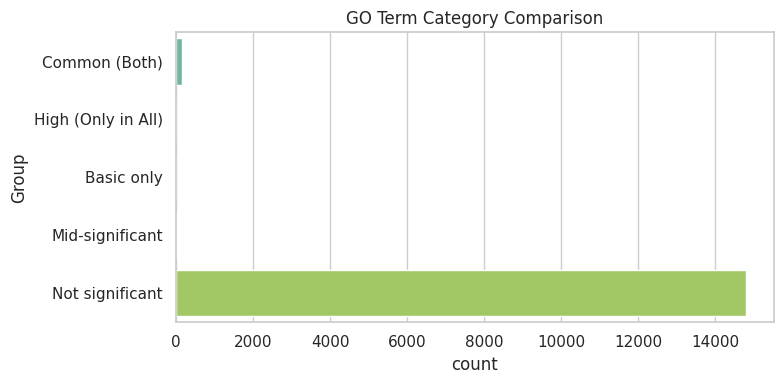

In [140]:
#don't use
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=df_merged, y="Group", order=[
    "Common (Both)",
    "High (Only in All)",
    "Basic only",
    "Mid-significant",
    "Not significant"
], palette="Set2")
plt.title("GO Term Category Comparison")
plt.tight_layout()
plt.show()

In [142]:
df_merged["Group"].value_counts()
#해석 결론

Group
Not significant       14783
Common (Both)           146
Mid-significant          38
High (Only in All)       12
Basic only                5
Name: count, dtype: int64

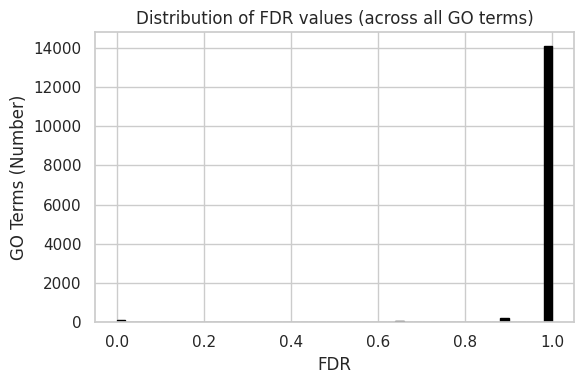

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(all_go_df["p_fdr_bh"], bins=50, color="black", edgecolor="black")
plt.xlabel("FDR")
plt.ylabel("GO Terms (Number)")
plt.title("Distribution of FDR values (across all GO terms)")
plt.tight_layout()
plt.show()

<ipython-input-153-671559754>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




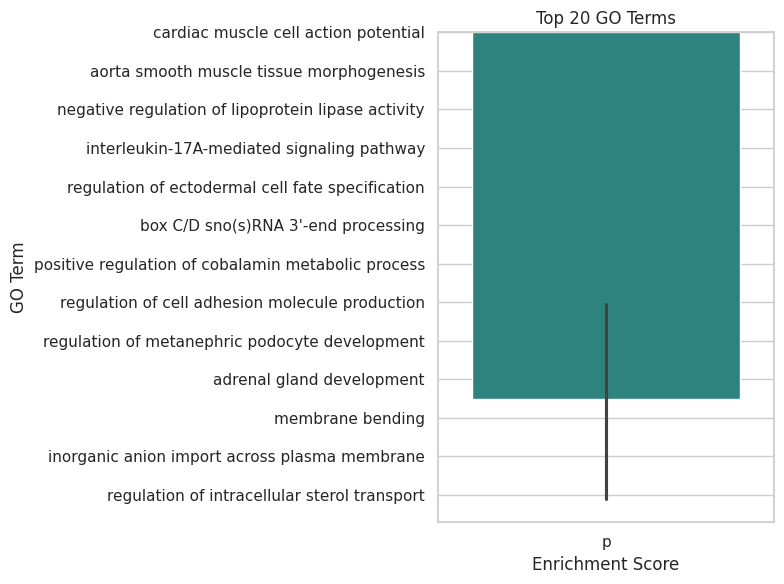

In [153]:
top_enrich = all_go_df.sort_values("Enrichment", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_enrich,
    y="Name",
    x="Enrichment",
    palette="viridis"
)
plt.title("Top 20 GO Terms")
plt.xlabel("Enrichment Score")
plt.ylabel("GO Term")
plt.tight_layout()
plt.show()

In [148]:
intermediate_df = all_go_df[all_go_df["p_fdr_bh"] < 0.1]
print("FDR < 0.1:", intermediate_df.shape[0])
intermediate_df.head(10)

FDR < 0.1: 201


GO                                               Name  \
0  GO:0006811                           monoatomic ion transport   
1  GO:0007186       G protein-coupled receptor signaling pathway   
2  GO:0019236                              response to pheromone   
3  GO:0034220             monoatomic ion transmembrane transport   
4  GO:0055085                            transmembrane transport   
5  GO:0050906  detection of stimulus involved in sensory perc...   
6  GO:0007218                     neuropeptide signaling pathway   
7  GO:0007600                                 sensory perception   
8  GO:0030001                                metal ion transport   
9  GO:0051606                              detection of stimulus   

   p_uncorrected  p_fdr_bh Enrichment Ratio_in_study Ratio_in_pop  \
0   9.652371e-07  0.000230          e        87/1384    998/27304   
1   3.230933e-06  0.000663          e       143/1384   1922/27304   
2   5.255525e-06  0.000972          e        18/1384    105/27304   
3   3.017975e-05  0.004433          e        69/1384    813/27304   
4   4.071249e-05  0.005701          e        97/1384   1257/27304   
5   7.396271e-05  0.009637          e        46/1384    495/27304   
6   1.346897e-04  0.015645          e        16/1384    110/27304   
7   2.081978e-04  0.023108          e       121/1384   1713/27304   
8   2.516555e-04  0.027524          e        57/1384    680/27304   
9   2.783295e-04  0.029789          e        51/1384    592/27304   

                                               Genes  
0  14658;110835;504186;225997;239436;22295;21906;...  
1  258341;14658;258147;14748;171469;237716;258247...  
2  171232;171259;113846;330485;171224;171240;1712...  
3  14658;320707;71699;226922;242735;110835;14405;...  
4  14658;110835;504186;225997;54670;239436;14580;...  
5  404308;259034;258494;83770;110835;12353;239766...  
6  14658;18976;20605;217212;50501;20394;14767;237...  
7  258341;14658;258147;258247;259119;258565;25906...  
8  226922;320707;71699;242735;20494;20278;319734;...  
9  404308;259034;258494;83770;110835;12353;239766...

In [149]:
#분석: GO enrichment 분석 결과를 DataFrame으로 정리 (GO ID, 이름, p-value, FDR, Enrichment score, ratio, gene list)
import pandas as pd

# FDR < 0.05
significant_terms = [r for r in results if r.p_fdr_bh < 0.05]
print(len(significant_terms))

go_enrich_df = pd.DataFrame([{
    "GO_ID": r.GO,
    "Description": r.name,
    "FDR": r.p_fdr_bh,
    "Study_Count": r.study_count,
    "Study_Total": r.study_n,
    "Pop_Count": r.pop_count,
    "Pop_Total": r.pop_n
} for r in significant_terms])

go_enrich_df = go_enrich_df.sort_values("FDR")
go_enrich_df.to_csv("TE_GO_enrichment_results.csv", index=False)
go_enrich_df.head(10)

158


GO_ID                                       Description  \
16  GO:0006139  nucleobase-containing compound metabolic process   
17  GO:0090304                    nucleic acid metabolic process   
18  GO:0044238                         primary metabolic process   
19  GO:0008152                                 metabolic process   
20  GO:0016070                             RNA metabolic process   
21  GO:0043170                   macromolecule metabolic process   
22  GO:0006396                                    RNA processing   
23  GO:0080090           regulation of primary metabolic process   
24  GO:0060255     regulation of macromolecule metabolic process   
25  GO:0019222                   regulation of metabolic process   

             FDR  Study_Count  Study_Total  Pop_Count  Pop_Total  
16  1.016894e-20           36         1384       2581      27304  
17  3.654084e-19           22         1384       1996      27304  
18  4.900011e-19          197         1384       6756      27304  
19  2.257737e-16          252         1384       7812      27304  
20  1.019252e-15           11         1384       1380      27304  
21  4.708412e-15          158         1384       5485      27304  
22  6.410230e-13            2         1384        824      27304  
23  1.097453e-09          171         1384       5322      27304  
24  2.991719e-09          203         1384       6013      27304  
25  3.025936e-09          227         1384       6549      27304

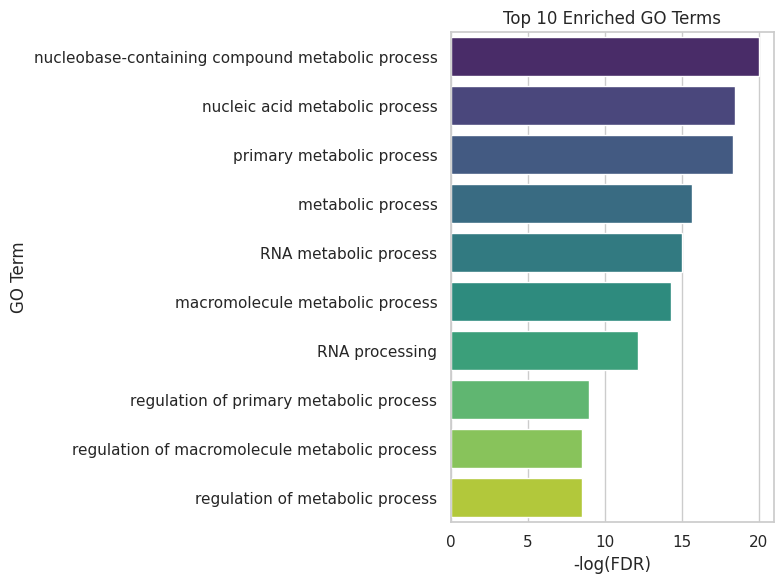

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_plot = go_enrich_df.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_plot,
    y="Description",
    x=-np.log10(top_plot["FDR"]),
    palette="viridis"
)
plt.xlabel("-log(FDR)")
plt.ylabel("GO Term")
plt.title("Top 10 Enriched GO Terms")
plt.tight_layout()
plt.show()

In [156]:
# GO enrichment 결과에서 FDR < 0.05인 항목만 추출
significant_terms = [r for r in results if r.p_fdr_bh < 0.05]
print("FDR < 0.05:", len(significant_terms))

FDR < 0.05: 158


In [157]:
import pandas as pd

go_df = pd.DataFrame([
    {
        "GO": r.GO,
        "Name": r.name,
        "p_uncorrected": r.p_uncorrected,
        "p_fdr_bh": r.p_fdr_bh,
        "Enrichment": r.enrichment,
        "Ratio_in_study": f"{r.study_count}/{r.study_n}",
        "Ratio_in_pop": f"{r.pop_count}/{r.pop_n}",
        "Genes": ";".join(r.study_items)
    }
    for r in significant_terms
])

print(go_df.shape[0])
go_df.head()

158


GO                                          Name  p_uncorrected  \
0  GO:0006811                      monoatomic ion transport   9.652371e-07   
1  GO:0007186  G protein-coupled receptor signaling pathway   3.230933e-06   
2  GO:0019236                         response to pheromone   5.255525e-06   
3  GO:0034220        monoatomic ion transmembrane transport   3.017975e-05   
4  GO:0055085                       transmembrane transport   4.071249e-05   

   p_fdr_bh Enrichment Ratio_in_study Ratio_in_pop  \
0  0.000230          e        87/1384    998/27304   
1  0.000663          e       143/1384   1922/27304   
2  0.000972          e        18/1384    105/27304   
3  0.004433          e        69/1384    813/27304   
4  0.005701          e        97/1384   1257/27304   

                                               Genes  
0  14658;110835;504186;225997;239436;22295;21906;...  
1  258341;14658;258147;14748;171469;237716;258247...  
2  171232;171259;113846;330485;171224;171240;1712...  
3  14658;320707;71699;226922;242735;110835;14405;...  
4  14658;110835;504186;225997;54670;239436;14580;...

In [158]:
# 파일 저장
go_df.to_excel("go_enrichment_fisher.xlsx", index=False)

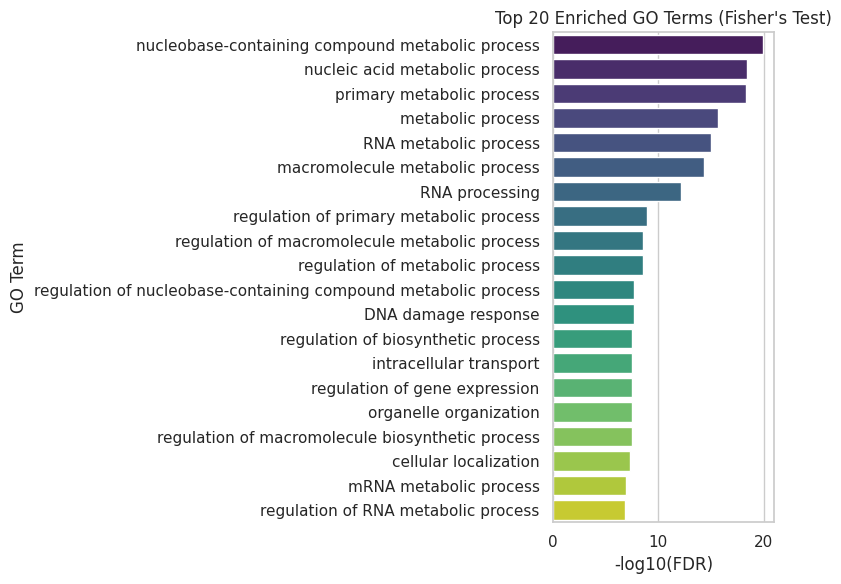

In [159]:
#수업시간에 배운 GO analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_n = 20
go_df_sorted = go_df.sort_values("p_fdr_bh").head(top_n)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=go_df_sorted,
    y="Name",
    x=-np.log10(go_df_sorted["p_fdr_bh"]),
    palette="viridis"
)
plt.xlabel("-log10(FDR)")
plt.ylabel("GO Term")
plt.title(f"Top {top_n} Enriched GO Terms (Fisher's Test)")
plt.tight_layout()
plt.show()

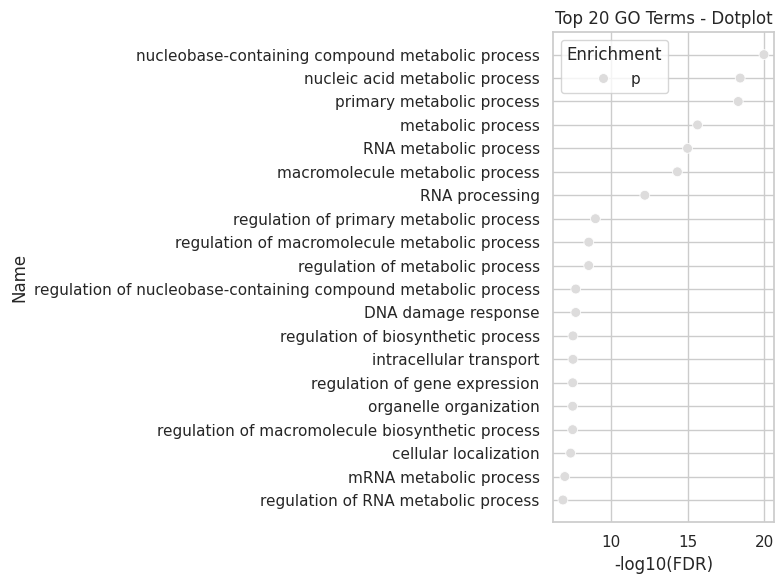

In [160]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=go_df_sorted,
    x=-np.log10(go_df_sorted["p_fdr_bh"]),
    y="Name",
    size="Enrichment",
    hue="Enrichment",
    palette="coolwarm",
    legend="full",
    sizes=(50, 300)
)
plt.xlabel("-log10(FDR)")
plt.title(f"Top {top_n} GO Terms - Dotplot")
plt.tight_layout()
plt.show()

In [162]:
#background 계산 시 fc 대신 fc_mapped 사용
background = fc_mapped["GeneID"].dropna()
background = background.astype(str).unique().tolist()

print("background:", len(background))

background: 27304


In [164]:
top_gene_ids = top_TE["GeneID"].dropna()
top_gene_ids = top_gene_ids.astype(float).astype(int).astype(str)
print("Target:", len(top_gene_ids))

Target: 1384


In [165]:
# 강제 변환 시도
gene2go_fixed = {str(k): v for k, v in gene2go.items()}

# 다시 GOEA 생성
goea = GOEnrichmentStudy(
    list(background),
    gene2go_fixed,
    obodag,
    methods=['fdr_bh'],
    alpha=0.05,
    prt=None
)

results = goea.run_study(list(top_gene_ids))
print("enrichment:", len(results))


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 68% 18,587 of 27,304 population items found in association

Runing  Ontology Analysis: current study set of 1384 IDs.
 62%    858 of  1,384 study items found in association
100%  1,384 of  1,384 study items found in population(27304)
Calculating 14,984 uncorrected p-values using fisher_scipy_stats
  14,984 terms are associated with 18,587 of 27,304 population items
   5,494 terms are associated with    858 of  1,384 study items
  METHOD fdr_bh:
     158 GO terms found significant (< 0.05=alpha) ( 16 enriched + 142 purified): statsmodels fdr_bh
     362 study items associated with significant GO IDs (enriched)
     858 study items associated with significant GO IDs (purified)
enrichment: 14984


In [172]:
# 교집합 유전자 수 확인
gene2go_ids = set(gene2go_strkeys.keys())
overlap = gene2go_ids.intersection(set(top_gene_ids))
print("Overlap:", len(overlap))

Overlap: 858


In [173]:
go_filtered.to_csv("go_df_filtered.csv", index=False)

In [176]:
# 예시
example_go = "GO:0006412"  # translation

genes_in_go = [str(gid) for gid, gos in gene2go.items() if example_go in gos]

intersect = set(genes_in_go).intersection(set(fc_mapped["GeneID"]))

print(f"GO:0006412 and fc_mapped overlap: {len(intersect)}")

GO:0006412 and fc_mapped overlap: 355


In [177]:
matched = fc_mapped[fc_mapped["GeneID"].isin(genes_in_go)]
print("Matched genes:", matched.shape[0])
#99개면 충분하다.

Matched genes: 355


In [ ]:
#끝

In [38]:
# 루프 점검: 처음 20개 GO term만 확인
go_data = []

for go_id, term in list(obodag.items())[:20]:  # 소량으로 테스트
    genes_in_go = [str(gid) for gid, gos in gene2go.items() if go_id in gos]
    matched = fc_mapped[fc_mapped["GeneID"].isin(genes_in_go)]

    print(f"{go_id} ({term.name}): matched {len(matched)} genes")

    if len(matched) >= 3:
        go_data.append({
            "GO_ID": go_id,
            "Description": term.name,
            "N_genes": len(matched),
            "avg_CLIP": matched["log2fc_CLIP"].mean(),
            "avg_RIBO": matched["log2fc_RIBO"].mean(),
            "avg_RNA": matched["log2fc_RNA"].mean()
        })

GO:0000001 (mitochondrion inheritance): matched 0 genes
GO:0000002 (mitochondrial genome maintenance): matched 14 genes
GO:0000006 (high-affinity zinc transmembrane transporter activity): matched 0 genes
GO:0000007 (low-affinity zinc ion transmembrane transporter activity): matched 0 genes
GO:0000009 (alpha-1,6-mannosyltransferase activity): matched 0 genes
GO:0000010 (heptaprenyl diphosphate synthase activity): matched 0 genes
GO:0000011 (vacuole inheritance): matched 0 genes
GO:0000012 (single strand break repair): matched 13 genes
GO:0000014 (single-stranded DNA endodeoxyribonuclease activity): matched 0 genes
GO:0000015 (phosphopyruvate hydratase complex): matched 0 genes
GO:0000016 (lactase activity): matched 0 genes
GO:0000017 (alpha-glucoside transport): matched 2 genes
GO:0000018 (regulation of DNA recombination): matched 1 genes
GO:0000019 (regulation of mitotic recombination): matched 1 genes
GO:0000022 (mitotic spindle elongation): matched 0 genes
GO:0000023 (maltose metabol

In [24]:
!ls -lh | grep gene2go

-rw------- 1 root root  8.9G Jun 12 03:53 gene2go
-rw------- 1 root root  568M Jun 12 05:09 gene2go_fixed
-rw------- 1 root root  1.2G Jun 12 06:07 gene2go_fixed.gz


In [180]:
df = pd.read_csv("read-counts.txt", sep="\t", comment="#")
df = df.set_index("Geneid")

df["log2fc_CLIP"] = np.log2((df["CLIP-35L33G.bam"] + 1) / (df["RNA-control.bam"] + 1))
df["log2fc_RNA"]  = np.log2((df["RNA-siLin28a.bam"] + 1) / (df["RNA-siLuc.bam"] + 1))
df["log2fc_RIBO"] = np.log2((df["RPF-siLin28a.bam"] + 1) / (df["RPF-siLuc.bam"] + 1))

fc_df = df[["log2fc_CLIP", "log2fc_RNA", "log2fc_RIBO"]].dropna()

fc_df.to_csv("log2fc_all_genes.csv")

print("Number of genes:", fc.shape[0])

Number of genes: 55359


In [14]:
fc_df = pd.read_csv("log2fc_all_genes.csv", index_col=0)
fc_df["gene_id_clean"] = fc_df.index.str.split(".").str[0]  # Ensembl ID만 남기기
#작동하지 않음

In [25]:
!wget https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene_info.gz
!gunzip gene_info.gz
#작동하지 않음

--2025-06-12 07:28:47--  https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene_info.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325322098 (1.2G) [application/x-gzip]
Saving to: ‘gene_info.gz.1’

gene_info.gz.1      100%[===================>]   1.23G  56.2MB/s    in 26s     

2025-06-12 07:29:13 (48.1 MB/s) - ‘gene_info.gz.1’ saved [1325322098/1325322098]



In [ ]:
!wc -l /content/drive/MyDrive/binfo1-work/gene_info

61198579 /content/drive/MyDrive/binfo1-work/gene_info


In [ ]:
%%R
# 3) Install BiocManager from CRAN, then Bioconductor packages
install.packages("BiocManager", repos="https://cloud.r-project.org", quiet=TRUE)
BiocManager::install(c("DESeq2","clusterProfiler","org.Mm.eg.db","cowplot"), ask=FALSE, update=FALSE, quiet=TRUE)